In [1]:
%matplotlib inline

In [2]:
# Імпорт необхідних бібліотек
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [3]:
# Налаштування пристрою
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Підготовка даних без аугментації
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'gameplay_data'  # Папка з даними
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [5]:
# Завантаження моделі EfficientNetB0
model_ft = models.efficientnet_b0(pretrained=True)
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

# Налаштування оптимізатора та функції втрат
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

D:\anaconda3\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda3\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\bveta/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100.0%


In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # На кожній епосі є фази тренування та фази валідації
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # режим тренування
            else:
                model.eval()   # режим валідації

            running_loss = 0.0
            running_corrects = 0

            # ітерація по батчах
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # обнулення градієнта
                optimizer.zero_grad()

                # проходження даних через модель
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # зворотнє поширення помилки та оптимізація тільки в режимі тренування
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # підраховую точність по батчах
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # оновлюю lr в режимі навчання
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # зберігання даних для найкращої моделі
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Навчання завершено за {time_elapsed // 60:.0f} хв {time_elapsed % 60:.0f} сек')
    print(f'Найкраща точність на валідаційній вибірці: {best_acc:4f}')

    # завантаження ваг для найкращої моделі
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
# Навчання моделі
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.6366 Acc: 0.8260
val Loss: 0.0971 Acc: 0.9720

Epoch 2/10
----------
train Loss: 0.1732 Acc: 0.9534
val Loss: 0.0517 Acc: 0.9850

Epoch 3/10
----------
train Loss: 0.1036 Acc: 0.9730
val Loss: 0.0450 Acc: 0.9855

Epoch 4/10
----------
train Loss: 0.0736 Acc: 0.9804
val Loss: 0.0496 Acc: 0.9840

Epoch 5/10
----------
train Loss: 0.0586 Acc: 0.9834
val Loss: 0.0387 Acc: 0.9875

Epoch 6/10
----------
train Loss: 0.0416 Acc: 0.9900
val Loss: 0.0251 Acc: 0.9925

Epoch 7/10
----------
train Loss: 0.0420 Acc: 0.9903
val Loss: 0.0312 Acc: 0.9900

Epoch 8/10
----------
train Loss: 0.0313 Acc: 0.9926
val Loss: 0.0280 Acc: 0.9905

Epoch 9/10
----------
train Loss: 0.0314 Acc: 0.9920
val Loss: 0.0376 Acc: 0.9895

Epoch 10/10
----------
train Loss: 0.0262 Acc: 0.9929
val Loss: 0.0364 Acc: 0.9890

Навчання завершено за 20 хв 23 сек
Найкраща точність на валідаційній вибірці: 0.992500


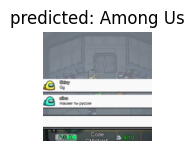

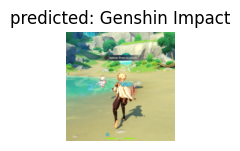

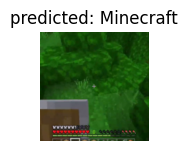

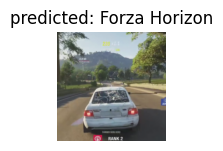

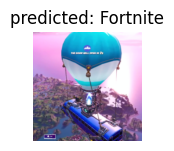

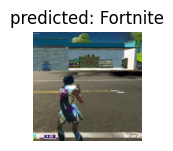

In [12]:
def imshow(inp, title=None):
    """Візуалізація на Tensorflow."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # пауза для оновлення

visualize_model(model_ft)

In [13]:
torch.save(model_ft, 'games_classification_model_exp2.pth')